In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=22513e3361919e176c93dec686910d18bf4e1fbd6482b8d86cdbe86952230c8a
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torch import Tensor, optim
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import wandb
from PIL import Image
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision.utils import make_grid

In [3]:
# wandb login
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Downloading and Loading Dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# Fitting data loaders for iterating
img_size = 28
batch_size = 64
z_size = 100
generator_layer_size = [128, 256, 512]
discriminator_layer_size = [512, 256, 128]
learning_rate = 1e-4

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True) 
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,
                                          shuffle=False)

In [6]:
# data iterator
data_iter = iter(train_loader)
images, labels = next(data_iter)
#image size is 28*28
img_size = images.shape[2]
print(images.shape)
# Create image grid
torchvision.utils.save_image(images, "Fashion MNIST_input_grid.jpg", nrow=16, padding=0, normalize=True)

torch.Size([64, 1, 28, 28])


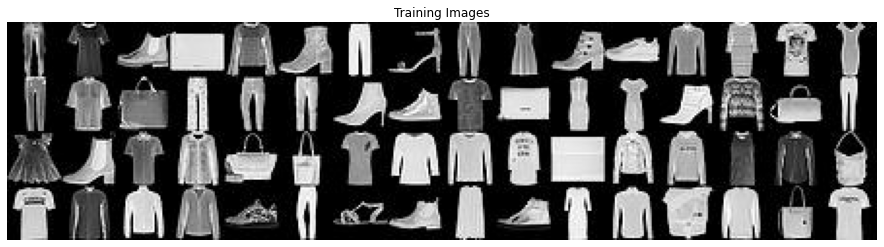

In [7]:
# Load training images grid and visualize using matplotlib
plt.figure(figsize=(16, batch_size/16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(Image.open("Fashion MNIST_input_grid.jpg"))

In [8]:
# dataset classes
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [9]:
# Generator class for generating fake images
class CGAN_Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)

        # generator_layer_size = [128, 256, 512]

        self.model = nn.Sequential(
            # 128
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # 128,256
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # 256,512
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # 512, 28*28
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, labels):
        z = z = torch.randn((len(labels), self.z_size), device=device)        
        # One-hot vector to embedding vector
        labels = self.label_emb(labels)
        # Concat image & label
        x = torch.cat([z, labels], 1)
        # Generator out
        out = self.model(x)
        return out.view(-1, self.img_size, self.img_size)


In [10]:
# Discriminator class for descriminating between fake and real images
class CGAN_Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        # discriminator_layer_size = [512, 256, 128]

        self.model = nn.Sequential(
            # 28*28, 512
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 512, 256
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 256, 128
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 128, 1
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)        
        # One-hot vector to embedding vector
        labels = self.label_emb(labels)        
        # Concat image & label
        x = torch.cat([x, labels], 1)
        # Discriminator out
        out = self.model(x)        
        return out.squeeze()


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# generator and discriminator
generator = CGAN_Generator(generator_layer_size, z_size, img_size, class_num).to(device)
discriminator = CGAN_Discriminator(discriminator_layer_size, img_size, class_num).to(device)

# initialize a wandb
wandb.init(project='cudalab-cgan-ws2022_2023', name='cgan_final_run')
# log frequency of gradients and parameters 100 by default
wandb.watch(discriminator, idx=0)
wandb.watch(generator, idx=1)


wandb: Currently logged in as: zohasheikh380 (cudalab2022). Use `wandb login --relogin` to force relogin


[]

In [13]:
# optimizer
generator_optimizer = optim.Adam(generator.parameters(),
                         lr=learning_rate, betas=(0.5, 0.999))

discriminator_optimizer = optim.Adam(discriminator.parameters(),
                         lr=learning_rate, betas=(0.5, 0.999))

# Binary cross entropy loss
criterion = nn.BCELoss().to(device)

In [14]:
# calculate generator loss
def generator_loss(fake_images,fake_labels, train):
    generator_loss = criterion(discriminator(
            fake_images, fake_labels), torch.ones_like(labels, device=device, dtype=torch.float))
    if(train == 1):
      generator_optimizer.zero_grad()
      generator_loss.backward()
      generator_optimizer.step()
    return generator_loss

In [15]:
# calculate discriminator loss
def discriminator_loss(images,labels, validation):
      discriminator_real_loss = criterion(discriminator(images, labels), torch.ones_like(labels, device=device, dtype=torch.float))
      discriminator_fake_loss = criterion(discriminator(
            fake_images.detach(), fake_labels), 1-torch.ones_like(labels, device=device, dtype=torch.float))
      discriminator_loss = discriminator_real_loss + discriminator_fake_loss
      if(validation == 1):
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
      return discriminator_loss

In [16]:
# trains the CGAN on 50 epochs and log the losses to wandb
for epoch in tqdm(range(50), total=50):
    # training
    generator.train()
    discriminator.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        fake_labels = torch.randint_like(labels, low=0, high=10, device=device)
        fake_images = generator(fake_labels)
        g_loss = generator_loss(fake_images, fake_labels, 1)
        d_loss = discriminator_loss(images,labels,1)
        # logs the losses to wandb
        wandb.log({'Generator training loss': g_loss,
                   'Discriminator training loss': d_loss
                  })

    # validation
    discriminator.eval()
    generator.eval()

    with torch.no_grad():
        for images, labels in validation_loader:
            # same as above
            images = images.to(device)
            labels = labels.to(device)
            fake_labels = torch.randint_like(
                labels, low=0, high=10, device=device)
            fake_images = generator.forward(fake_labels)
            g_loss = generator_loss(fake_images, fake_labels, 0)
            d_loss = discriminator_loss(images,labels, 0)
             # logs the losses to wandb
            wandb.log({'Generator validation loss': g_loss,
                   'Discriminator validation loss': d_loss
                  })


100%|██████████| 50/50 [37:30<00:00, 45.02s/it]


In [17]:
# testing the generator's capabilities with random labels
labels =  Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)
fake_images = generator(labels)
prediction_score = discriminator(fake_images, labels)
# write the predictions back to wandb as a summary [image,label,prediction score]
prediction_table = wandb.Table(
    columns=['image', 'label', 'prediction'])
for i in range(100):
    prediction_table.add_data(wandb.Image(fake_images[i]), labels[i], prediction_score[i])
wandb.log({"final predictions": prediction_table})


In [18]:
# ends the current active session
wandb.finish(quiet=True)